In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import geonamescache
from scipy.ndimage import gaussian_filter1d

## Data Loading and Initial Preprocessing

In this section, we will perform the initial steps to load and preprocess the job data. The steps include:

1. **Load CSV Data**: Load the job data from a CSV file into a pandas DataFrame.
2. **Drop NaN Values**: Remove rows where the 'minimum_salary' column has NaN values to ensure data consistency.
3. **Convert Timestamps**: Convert the 'job_timestamp' column to datetime format for easier manipulation and analysis.
4. **Display Data**: Display the first few rows of the DataFrame to verify the data loading and preprocessing steps.

These steps are crucial for preparing the data for further analysis and visualization.

In [2]:
# Load the CSV data into a DataFrame
df = pd.read_csv('job_data.csv')

# Drop rows where 'minimum_salary' is NaN
df = df.dropna(subset=['minimum_salary'])

# Convert timestamp to datetime
df['job_timestamp'] = pd.to_datetime(df['job_timestamp'])

# Display the first few rows to verify
df.head()

,job_title,company,minimum_salary,maximum_salary,currency,technology,primary_location_city,primary_location_country,remote,job_timestamp
10,Remote Node.js Developer,RST Software Masters,9000.0,18000.0,PLN,Node.js,Świdnica,Poland,True,2022-05-13
11,Node.js Developer,Boldare,9000.0,15700.0,PLN,Node.js,Wrocław,Poland,True,2022-05-13
12,Software Developer (.NET),Apptio,14000.0,22000.0,PLN,.NET,Kraków,Poland,False,2022-05-13
13,AWS Engineer,Spyrosoft,18480.0,29400.0,PLN,AWS,Wroclaw,Poland,False,2022-05-13
25,Mid DevOps/ SecOps Engineer,Zebra Technologies,8000.0,11000.0,PLN,NaN,Gliwice,Poland,False,2024-02-17


## Data Preprocessing and Conversion

In this section, we will preprocess the job data by performing the following steps:
1. Load the CSV data into a DataFrame.
2. Drop rows where 'minimum_salary' is NaN.
3. Convert the 'job_timestamp' column to datetime format.
4. Display the first few rows of the DataFrame to verify the data.

We will also define functions to:
- Get the country from a city name using the `geonamescache` library.
- Convert salaries to USD based on exchange rates.
- Normalize salaries to ensure consistency.

Additionally, we will define exchange rates and cost of living indices for various countries, and annotate major tech layoff events for future analysis.

In [3]:
# Exchange rates to USD (as of February 15, 2025)
exchange_rates = {
    'PLN': 0.2525, 'CHF': 1.057, 'EUR': 1.0478, 'HUF': 0.0026, 'CZK': 0.0399, 'USD': 1.0
}

# Cost of living index relative to the US (approximate values)
cost_of_living = {
    'Poland': 0.55,
    'Switzerland': 1.25,
    'Germany': 0.85,
    'United States': 1.0,
    'Hungary': 0.50,
    'Cyprus': 0.70
}

# Annotate major tech layoffs
layoff_events = [
    ('2022-11-01', 'Meta Layoffs (11,000)'),
    ('2023-01-01', 'Amazon Layoffs (18,000)'),
    ('2023-05-01', 'Google & Microsoft Layoffs (12,000 & 10,000)'),
    ('2023-11-01', 'Salesforce Layoffs (7,000)')
]

# Ensure cost_of_living is defined within the scope
globals()['cost_of_living'] = cost_of_living

# Initialize geonames cache
gc = geonamescache.GeonamesCache()

# Get countries and cities data
countries = gc.get_countries()
cities = gc.get_cities()

def get_country_from_city(city_name):
    for city in cities.values():
        if city['name'].lower() == city_name.lower():
            country_code = city['countrycode']
            return countries[country_code]['name'] if country_code in countries else None
    return None

def convert_salary_to_usd(row):
    min_salary, max_salary, currency = row['minimum_salary'], row['maximum_salary'], row['currency']
    country, city = row['primary_location_country'], row['primary_location_city']

    if pd.isna(currency):
        if pd.notna(country):
            currency = exchange_rates.get(country, 'USD')
        elif pd.notna(city):
            inferred_country = get_country_from_city(city)
            currency = exchange_rates.get(inferred_country, 'USD')
        else:
            currency = 'USD'

    if max_salary < 50000:
        min_salary *= 12
        max_salary *= 12

    exchange_rate = exchange_rates.get(currency, 1.0)
    return pd.Series([min_salary * exchange_rate, max_salary * exchange_rate])

def normalize_salary(row):
    min_salary, max_salary = row['min_salary_usd'], row['max_salary_usd']
    if max_salary < 50000:
        min_salary *= 12
        max_salary *= 12
    return pd.Series([min_salary, max_salary])

## Salary Conversion and Normalization

In this section, we will perform the following steps to preprocess the salary data:

1. **Convert Salaries to USD**: We will convert the minimum and maximum salaries to USD using the exchange rates defined earlier. This will make the salaries easier to work with and compare.

In [4]:
# Convert Salaries to USD to make them easier to work with
df[['min_salary_usd', 'max_salary_usd']] = df.apply(convert_salary_to_usd, axis=1)

# Normalize salaries (a salary of <50k is probably a yearly salary)
df[['minimum_salary', 'maximum_salary']] = df.apply(normalize_salary, axis=1)

# Adjust salaries by cost of living
df['adjusted_max_salary_usd'] = df.apply(lambda x: x['max_salary_usd'] / globals()['cost_of_living'].get(x['primary_location_country'], 1.0), axis=1)

# Calculate overall quarterly average salary
quarterly_avg_salary = df.resample('QE', on='job_timestamp')['adjusted_max_salary_usd'].mean().reset_index()

## Visualization of Adjusted Max Salary Over Time

In this section, we will visualize the cost of living adjusted maximum salary in USD per quarter. We will perform the following steps:

1. **Resample Data**: Resample the data to calculate the quarterly average of the adjusted maximum salary.
2. **Smooth Data**: Apply a Gaussian filter to smooth the salary data for better visualization.
3. **Plot Data**: Plot the smoothed salary data over time.
4. **Annotate Layoff Events**: Annotate the plot with major tech layoff events to provide context.

The resulting plot will help us understand the trend of adjusted maximum salaries over time and the impact of major layoff events on these salaries.

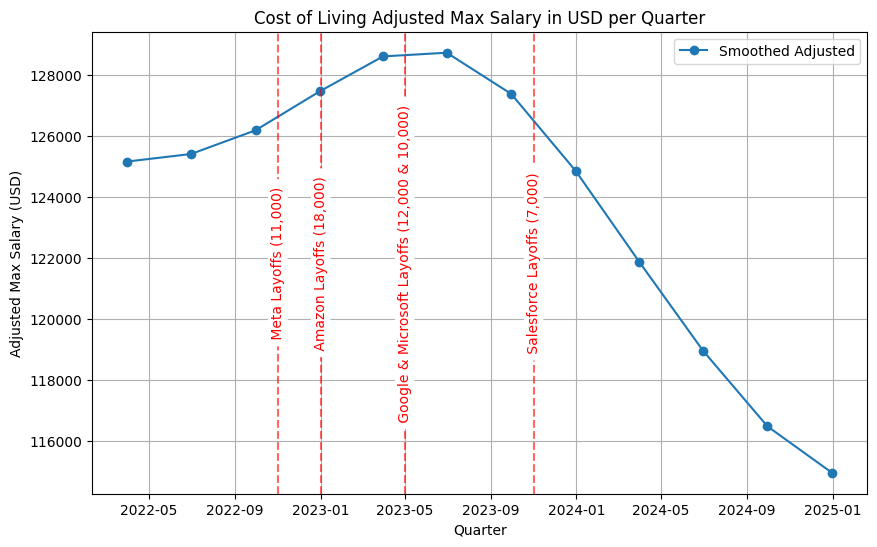

In [5]:
quarterly_avg = df.resample('QE', on='job_timestamp')['adjusted_max_salary_usd'].mean().reset_index()
smoothed_salaries = gaussian_filter1d(quarterly_avg['adjusted_max_salary_usd'], sigma=2)

plt.figure(figsize=(10, 6))
plt.plot(quarterly_avg['job_timestamp'], smoothed_salaries, marker='o', label='Smoothed Adjusted')

for date, label in layoff_events:
    plt.axvline(pd.to_datetime(date), color='red', linestyle='--', alpha=0.6)
    plt.text(pd.to_datetime(date), (plt.ylim()[0] + plt.ylim()[1]) / 2, ' ' + label + ' ', rotation=90, color='red', ha='center', va='center', bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.2'))


plt.title('Cost of Living Adjusted Max Salary in USD per Quarter')
plt.xlabel('Quarter')
plt.ylabel('Adjusted Max Salary (USD)')
plt.grid(True)
plt.legend()

# Save the plot to a file
plt.savefig('docs/adjusted_max_salary_plot.png', dpi=300, bbox_inches='tight')

plt.show()

## Comparison of Remote vs Non-Remote Jobs

In this section, we will compare the cost of living adjusted maximum salaries for remote and non-remote jobs over time. We will perform the following steps:

1. **Filter Data**: Separate the data into remote and non-remote job postings.
2. **Resample Data**: Calculate the quarterly average of the adjusted maximum salary for both remote and non-remote jobs.
3. **Smooth Data**: Apply a Gaussian filter to smooth the salary data for better visualization.
4. **Plot Data**: Plot the smoothed salary data for both remote and non-remote jobs over time.
5. **Annotate Layoff Events**: Annotate the plot with major tech layoff events to provide context.

The resulting plot will help us understand the trends in adjusted maximum salaries for remote versus non-remote jobs and the impact of major layoff events on these salaries.

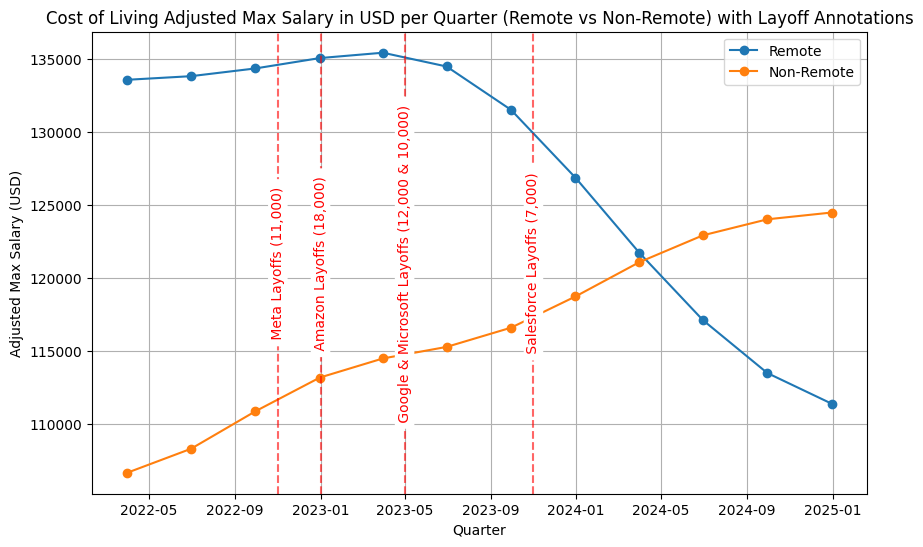

In [6]:
# Filter data for remote and non-remote jobs
remote_jobs = df[df['remote'] == True]
non_remote_jobs = df[df['remote'] != True]

# Resample and calculate quarterly averages
remote_avg = remote_jobs.resample('QE', on='job_timestamp')['adjusted_max_salary_usd'].mean().reset_index()
non_remote_avg = non_remote_jobs.resample('QE', on='job_timestamp')['adjusted_max_salary_usd'].mean().reset_index()

# Apply smoothing
remote_smoothed = gaussian_filter1d(remote_avg['adjusted_max_salary_usd'], sigma=2)
non_remote_smoothed = gaussian_filter1d(non_remote_avg['adjusted_max_salary_usd'], sigma=2)

# Plot both lines
plt.figure(figsize=(10, 6))
plt.plot(remote_avg['job_timestamp'], remote_smoothed, marker='o', label='Remote')
plt.plot(non_remote_avg['job_timestamp'], non_remote_smoothed, marker='o', label='Non-Remote')

for date, label in layoff_events:
    plt.axvline(pd.to_datetime(date), color='red', linestyle='--', alpha=0.6)
    plt.text(pd.to_datetime(date), (plt.ylim()[0] + plt.ylim()[1]) / 2, ' ' + label + ' ', rotation=90, color='red', ha='center', va='center', bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.2'))

plt.title('Cost of Living Adjusted Max Salary in USD per Quarter (Remote vs Non-Remote) with Layoff Annotations')
plt.xlabel('Quarter')
plt.ylabel('Adjusted Max Salary (USD)')
plt.grid(True)
plt.legend()

# Save the plot to a file
plt.savefig('docs/adjusted_max_salary_plot_remove_vs_non_remote.png', dpi=300, bbox_inches='tight')

plt.show()
